# Explainer notebook

## Motivation
The data used for this project consists of wikipedia pages for all artists from the lists of [West Coast Hip Hop](https://en.wikipedia.org/wiki/List_of_West_Coast_hip_hop_artists) artists and [Dance Pop](https://en.wikipedia.org/wiki/List_of_dance-pop_artists) artists.
Furthermore, [Genius](https://genius.com) has been scraped to obtain song lyrics for each artist. The number of artists in each genre is approximately the same, which enables us to generate
a network without having to worry about problems caused by differences in amount of data. In addition, these two genres are expected to have somewhat of an overlap, while still being
distinct enough to form clear clusters in a network. 

Another reason behind our choice of data is practicality. The wikipedia pages are easily downloaded, and can be directly interpreted as a network, where the pages are nodes and the 
links between pages are edges. This construction lends itself well to graph analysis. We decided to use song lyrics as our secondary dataset (**er det sandt?**), as these include word
usage over time, allowing for some interesting sentiment analysis. 

We aimed to make relatively complex data analysis more digestible, by using relatable data that most people have knowledge of. This is also reflected in the simplicity of our [website](https://nadjariis.github.io/SocialGraphs2020/),
which should ideally be comprehensible for all interested readers. The following sections in this notebook will further explain the process of preparing the data, as well as the 
various tools and methods of analysis that we have applied to the data.

## Data Preparation and Basic Stats

### Downloading wikipedia pages
The majority of the work here lies in scraping the lists of West Coast Hip Hop and Dance Pop artists, such that we get only the names of the artists from those two lists. 
Once we have two nice lists containing only the artists, downloading the actual text from all the wikipedia pages is relatively straightforward.

We start out by simply making a list of all links found on each of the two wikipedia lists. This will however create a few issues with the Dance Pop artists, as the list containing
those artists has a whole bunch of references at the bottom of the page. These will also be interpreted as links by our regular expression. As a result of this, we ended up manually creating
a list of all Dance Pop artists (called `DancePop_artists.txt`), and simply using this list to determine the links to the wikipedia pages of those artists.



In [ ]:
!pip install ftfy

     |████████████████████████████████| 64 kB 4.5 MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-py3-none-any.whl size=45612 sha256=4c79ed117b84cdb561595a7e2d4e291922f8fe455bca01324f625f289412de9f
  Stored in directory: /home/jovyan/.cache/pip/wheels/49/1c/fc/8b19700f939810cd8fd9495ae34934b246279791288eda1c31
Successfully built ftfy
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# First, some imports
import pandas as pd
import re
import urllib.request
import json
import ftfy

In [ ]:
# Define urls
url_west_coast = "https://en.wikipedia.org/wiki/List_of_West_Coast_hip_hop_artists"
url_dance_pop = "https://en.wikipedia.org/wiki/List_of_dance-pop_artists"

In [ ]:
# Function to create lists of links to the wikipedia pages 
# input: url to scrape for links and name of the page to scrape

def link_list(url, sitename): 

    # for creating query
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles="+ sitename
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    # get text from wikipedia page
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    # find all links in text
    linklist  = re.findall("\[\[(.*?)\]\]", wikitext)
    
    return linklist

In [ ]:
# Create lists containing all links from the two websites
links_west_coast = link_list(url_west_coast, "List_of_West_Coast_hip_hop_artists")
links_dance_pop = link_list(url_dance_pop, "List_of_dance-pop_artists")

# Get all the actual Dance Pop artists from manually created file
dance_pop_artists =  open("./DancePop_artists.txt","r").read().split('\n')

In [ ]:
# Remove none artist links from links_west_coast
links_west_coast = links_west_coast[1:-3] 

# Use DancePop_artists file to clean links_dance_pop, such that it only contains links to artists
clean_links_dance_pop = [] 
for artist in links_dance_pop:
    artist_clean = ftfy.fixes.decode_escapes(artist)
    artist_clean_split = artist_clean.split('|')

    if len(artist_clean_split) > 1:
        if artist_clean_split[1] in dance_pop_artists:
            clean_links_dance_pop.append(artist_clean)

    elif len(artist_clean_split) == 1:
        if artist_clean_split[0] in dance_pop_artists:
            clean_links_dance_pop.append(artist_clean)

# links_dance_pop will now only contain links to artists
links_dance_pop = clean_links_dance_pop

Since we now have two lists containing only links to artists from the two genres, we choose to create a dataframe containing the name of the artist, the wikipedia link name
and the genre of the artist. 

In [ ]:
# Create dataframe containing artist name, wikilink and genre
def create_dataframe(linklist, genre): 
    artistname = []
    wikilink = []
    genres = []

    for artist in linklist: 
        if '|' in artist: 
            artist_split = artist.split('|')
            artistname.append(artist_split[1])
            wikilink.append(artist_split[0].replace(' ', '_'))
            genres.append(str(genre))
        else: 
            artistname.append(artist)
            wikilink.append(artist.replace(' ', '_'))
            genres.append(str(genre))

    df = pd.DataFrame(list(zip(artistname, wikilink, genres)), columns =['Artist', 'WikiLink', 'Genre']) 

    return df 

In [ ]:
# Create two dataframes
west_coast_df = create_dataframe(links_west_coast, 'West Coast')
dance_pop_df = create_dataframe(links_dance_pop, 'Dance Pop')

In [ ]:
# Fix a few errors manually and save dataframes to csv
dance_pop_df.loc[37].Artist = 'Black Eyed Peas'
dance_pop_df.loc[37].WikiLink = 'Black_Eyed_Peas'
west_coast_df = west_coast_df.drop(1) # remove "11/5"

west_coast_df.to_csv('west_coast_df.csv', index=False)
dance_pop_df.to_csv('dance_pop_df.csv', index=False)

Finally, we are ready to download the actual text from each wikipedia page to use for further analysis. We simply save the content of each wikipedia page as a .txt file with
the name being the wikipedia link to the artist (e.g. `Bad_Boys_Blue.txt` for artist Bad Boys Blue). 

In [ ]:
# Function to retrieve content of wikipedia pages
# input: dataframe containing links to pages, and path where file should be saved

def get_wikitext(df, path): 
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    redirects = "redirects"
    
    for link in df['WikiLink']:
        try: 
            title = link
            query = "{}{}&{}&titles={}&{}&{}".format(baseurl, action, content, title, dataformat, redirects)
            
            # fix utf8
            query = query.replace("é", "%C3%A9")
            query = query.replace("á","%C3%A1")
            query = query.replace("í","%C3%AD")
            query = query.replace("ë","%C3%AB")
            query = query.replace("ä","%C3%A4")
            query = query.replace("ó","%C3%B3")
            query = query.replace("Á","%C3%81")

            wikiresponse = urllib.request.urlopen(query)
            wikidata = wikiresponse.read()
            wikitext = wikidata.decode('utf-8')

            with open(path + link + '.txt', 'w') as outfile:
                json.dump(wikitext, outfile)
        except: 
            print('Could not find ' + link)

In [ ]:
# Use function to extract wikipages for artist 
#path = '/home/jovyan/work/wikipages_west_coast/'
#get_wikitext(west_coast_df, path)

#path = '/home/jovyan/work/wikipages_dance_pop/'
#get_wikitext(dance_pop_df, path)

### Downloading song lyrics

In the analysis we want to use two different approache to text analysis, one analyzing network of links between
wikipages and another analyzing the words and sentiment of each artist song lyrics. 

Therefor we needed to download the songs for each artist from the Dance Pop and West Coast genre. 
For this purpose we used the genius API. Genius is a website which host artist names and their 
corresponding song lyrics. First of using the genius API we collect the artist id based on their each 
artists name.  



In [ ]:
# Requirements
!pip install bs4==0.0.1
!pip install pandarallel

     |████████████████████████████████| 115 kB 17.9 MB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=d057080756716936a18fdb3b5fd4279b48d767b27c15b5850a6a506d22ada398
  Stored in directory: /home/jovyan/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
  Created wheel for pandarallel: filename=pandarallel-1.5.1-py3-none-any.whl size=17126 sha256=8d8b00a0357d99bad5385a377627d0b8c8c08fa50067a94c9a94a2f2a04d9b56
  Stored in directory: /home/jovyan/.cache/pip/wheels/bd/da/5f/2e65e230a994adb965df002373975e66b3bd1cb90c0706b9ac
Successfully built pandarallel
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import re
import numpy as np
import requests

import urllib.request
import urllib.parse

import json
from bs4 import BeautifulSoup
from pandarallel import pandarallel

In [ ]:
# Constants
base = "https://api.genius.com"
client_access_token = "-q1tRGBZMEOk6JewZCC_KWZBxyFSg9nccGlX11Cb3MxpGpzWG4FBSJIXCJS33D3x"

Fetching the artist id from the html of each artist page on genius. The artist id is always after the following 
text in the html file '/genius/artists/', therefore we extracted the id between the line and a newline.     

In [ ]:
def get_artist_id(artist_name):
    url = "https://genius.com/artists/"
    req = urllib.request.Request(url+artist_name, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read().decode('utf-8')    
    id_artist = int((html.split('/genius/artists/')[1]).split("\" ")[0])
    return id_artist

In [ ]:
def get_all_ids(df): 
    id_list = []
    for index, row in df.iterrows(): # .iloc[1:]
        name = row['Artist'].replace(" ", "-").replace("é", "e")
        try: 
            artist_id = get_artist_id(name)
            id_list.append(artist_id)
            print(row['Artist'] + " with id: " + str(artist_id))
        except: 
            print("Artist "+row['Artist']+" not found.")
            id_list.append(np.nan)
    return id_list

Next up is using the artist id to extract the ids for all songs produced by the artist. It keeps all 
song ids, where the artist is the primary artist on the song. Also and extra function where added 
to run the code in parallel on the dataframe containing the artist id.  

In [ ]:
def get_song_id(artist_id):
    '''Get all the song id from an artist.'''
    current_page = 1
    next_page = True
    songs = [] # to store final song ids

    while next_page:
        path = "artists/{}/songs/".format(artist_id)
        params = {'page': current_page} # the current page
        data = get_json(path=path, params=params) # get json of songs

        page_songs = data['response']['songs']
        if page_songs:
            # Add all the songs of current page
            songs += page_songs
            # Increment current_page value for next loop
            current_page += 1

        else:
            # If page_songs is empty, quit
            next_page = False


    # Get all the song ids, excluding not-primary-artist songs.
    songs = [song["id"] for song in songs
            if song["primary_artist"]["id"] == artist_id]

    return songs

In [ ]:
def func_song_id(row): 
    artist_id = row['Artist id']
    if not np.isnan(artist_id):
        # Get song id's
        songs_ids = get_song_id(int(artist_id))
    else:  
        songs_ids = np.nan
    return songs_ids

Now we have an artist with an artist id and for each artist we can extract ids for all their songs. Then 
we just need to get all lyrics from genuis based on the songs ids. In the following we extracted 
lyrics for all songs based on song ids and connected them to each individual artist.   

In [ ]:
def retrieve_lyrics(song_id):
    '''Retrieves lyrics from html page.'''
    path = connect_lyrics(song_id)

    URL = "http://genius.com" + path
    page = requests.get(URL)

    # Extract the page's HTML as a string
    html = BeautifulSoup(page.text, "html.parser")

    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    return lyrics

In [ ]:
def func_song_lyric(row): 
    songs_ids = row['Song id']
    if not np.isnan(songs_ids).any():
        try: 
            # Scrape lyrics from the songs
            song_lyrics = [retrieve_lyrics(song_id) for song_id in songs_ids]
        except: 
            song_lyrics = np.nan
    else:  
       song_lyrics = np.nan
    return song_lyrics

Then we need to load in the csv-files containing the artist names and then use the previous described 
functions. The data is then stored in a new csv-file which will be used for analysis. 

In [ ]:
# Reading artist from csv files 
dance_pop_df = pd.read_csv('dance_pop_df.csv')
west_coast_df = pd.read_csv('west_coast_df.csv')

In [ ]:
pandarallel.initialize()
# Loading and storing the new data into first a dataframe and then a csv-file
dance_pop_df['Artist id'] = get_all_ids(west_coast_df)
dance_pop_df['Song id'] = dance_pop_df.parallel_apply(func_song_id, axis=1)
dance_pop_df['Song Lyrics'] = dance_pop_df.parallel_apply(func_song_lyric, axis=1)
dance_pop_df.to_csv("song_dance_pop_df.csv", sep='\t', encoding='utf-8')

west_coast_df['Artist id'] = get_all_ids(west_coast_df)
west_coast_df['Song id'] = west_coast_df.parallel_apply(func_song_id, axis=1)
west_coast_df['Song Lyrics'] = west_coast_df.parallel_apply(func_song_lyric, axis=1)
west_coast_df.to_csv("song_west_coast_df.csv", sep='\t', encoding='utf-8')

So the files song_dance_pop_df.csv and song_west_coast_df.csv contains the artist, artist id, song ids 
and list of lyrics for each artist. 

So for further analysis of each individual songs, we will create a dataframe with 
the artist, co-artists, release date, genre and lyrics for each song in the two different genres. 


In [ ]:
# Reading artist from csv files 
song_dance_pop_df = pd.read_csv('song_dance_pop_df.csv', sep='\t')
song_west_coast_df = pd.read_csv('song_west_coast_df.csv', sep='\t')

In [ ]:
get_song_information_global_count = 0
def get_song_information(song_ids, artist, artist_id, genre):
    '''Retrieve meta data about a song.'''
    # initialize a dictionary.
    song_list = []
    global get_song_information_global_count
    get_song_information_global_count += 1

    for i, song_id in enumerate(song_ids):
        try:
            path = "songs/{}".format(int(song_id))
            data = get_json(path=path)["response"]["song"]

            song_list.append({
                "title": data["title"],
                "release_date": data["release_date"] if data["release_date"] else "unidentified",
                "artist": artist, 
                "artist_id": artist_id, 
                "featured_artists":[feat["name"] if data["featured_artists"] else "" for feat in data["featured_artists"]],
                "genius_track_id": song_id,
                "genre": genre}
                )
        except:
            print("Failed with song id '{}'".format(song_id))
    return song_list

In [ ]:
# One example using the West Coast data 

columns_to_copy = ['Genre', 'Song id', 'Artist', 'Artist id']
df_new = pd.DataFrame(columns=columns_to_copy, data=song_west_coast_df[columns_to_copy].values)
df_new = df_new.loc[df_new['Artist id'].notnull()]
df_new['song_info'] = df_new.apply(lambda x: get_song_information(x['Song id'][1:-1].split(", "), x['Artist'], x['Artist id'], x['Genre']), axis=1)

song_info_2d_list = df_new['song_info'].tolist()
song_info_1d_list = sum(song_info_2d_list, []) ## https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy

df = pd.DataFrame(song_info_1d_list)

This creates two dataframes with the genre, song id, release date, artist, artist id, featured artists
 and lyrics for all songs one for genre.  

### Constructing network
Now that we have the content of all the wikipedia pages, we are ready to find all links between pages and create a directed graph with artists as nodes and links as edges.

In [ ]:
# First, more imports
import networkx as nx
import numpy as np
import io
import collections
from community import community_louvain
from networkx.algorithms import community
from collections import Counter 
from heapq import nlargest
from heapq import nsmallest
import math

# For plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from fa2 import ForceAtlas2
from wordcloud import WordCloud
from pyvis.network import Network

# import
import glob
from pathlib import Path

# nltk
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

In [ ]:
# Function to find all links on wikipedia pages and create network
# input: dataframe containing artists

def create_network(df): 
    for index, row in df.iterrows():
        if sum(df.Artist == row['Artist']) > 1:
            G.add_node(row['Artist'], genre = 'Both')
        else:
            G.add_node(row['Artist'], genre=row['Genre'])
            
    for index, row in df.iterrows():
        if row['Genre'] == 'Dance Pop':
            path_folder = './wikipages_dance_pop/'
        else:
            path_folder = './wikipages_west_coast/'
        text = io.open(path_folder+row['WikiLink']+'.txt','r',encoding = 'utf-8').read()
        links = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', text) # Find the links
        links = set(links).intersection(set(df['Artist'].unique())) # Remove no artists
       
        for link in links: # Add edges between the artists and the links
            G.add_edges_from([(link, row['Artist'])])

In [ ]:
dance_pop_df = pd.read_csv('dance_pop_df.csv')
west_coast_df = pd.read_csv('west_coast_df.csv')

G = nx.DiGraph()

# In order to obtain a network containing artists from both genres, we will concatenate the two dataframes 
artists = pd.concat([dance_pop_df, west_coast_df])
artists = artists.dropna()
artists = artists.reset_index()

create_network(artists)

# Remove nodes with no connections
G.remove_nodes_from(list(nx.isolates(G)))

Now the network is created, we have a look at some basic stats. Firstly we want to investigate the number of nodes and edges. After that, we want to look at the number of in- and out-degrees. 

In [ ]:
Print("The number of nodes in the artist network are:" G.number_of_nodes())
Print("The number of edges in the artist network are:", G.number_of_edges())

In [ ]:
deg_out = G.out_degree()
deg_out = np.asarray(deg_out)
degrees_out = deg_out[:,1]
degrees_out = [int(i) for i in degrees_out]

print("Min out-degree:", min(degrees_out))
print("Max out-degree:", max(degrees_out))

In [ ]:
deg_in = G.in_degree()
deg_in = np.asarray(deg_in)
degrees_in = deg_in[:,1]
degrees_in = [int(i) for i in degrees_in]

print("Min in-degree:", min(degrees_in))
print("Max in-degree:", max(degrees_in))

Having created the network, let's take a look at the degree distributions.

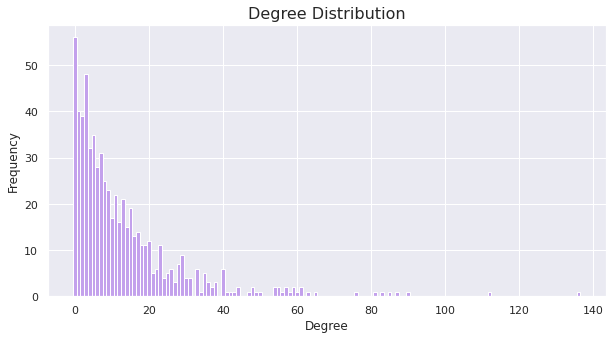

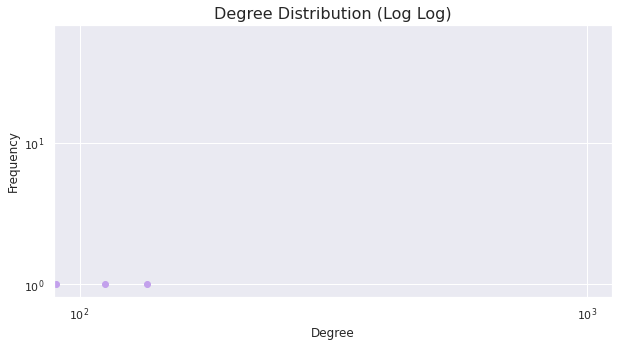

In [ ]:
#Plot the degree distribution
degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#C3A1EC")
plt.title("Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#C3A1EC")
plt.xscale('log')
plt.yscale('log')
plt.title("Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)

plt.show()

In [ ]:
#Plot the in-degree distribution
degree_sequence = sorted([d for n, d in G.in_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#65EAF1")
plt.title("In Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
plt.savefig('INDegreeDistribution.png', type='PNG')

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#65EAF1")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("In Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)
plt.savefig('INDegreeDistributionLog.png', type='PNG')

plt.show()

In [ ]:
#Plot the out-degree distribution
degree_sequence = sorted([d for n, d in G.out_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#63F2B1")
plt.title("Out Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
plt.savefig('OUTDegreeDistribution.png', type='PNG')


fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#63F2B1")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Out Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)
plt.savefig('OUTDegreeDistributionLog.png', type='PNG')


plt.show()

Next, we can construct a representation of the graph to show on the website. For a basic overview of the largest nodes, we will be constructing a graph using pyvis (it looks neat, and it's interactive!).
For a more complex graph with all artists, we will be usign networkx, as this allows for recoloring of edges (resulting in another cool graph!). The positions of the nodes will be
determined using ForceAtlas. 



In [ ]:
# Ready graph for plotting
H = G.to_undirected()
H.remove_edges_from(list(nx.selfloop_edges(H)))
GCC = max((H.subgraph(c) for c in nx.connected_components(H)), key=len)
nodeDict = dict(GCC.nodes(data=True))

First, we determine the node positions with ForceAtlas.

In [ ]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=False,
                        gravity=0.5,

                        # Log
                        verbose=True)

# Determine node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)

In order to make the basic graph, we will need to add a whole bunch of attributes to the nodes. These attributes will be used with the pyvis graph and a homemade networkx 
integration from this kind [person](https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e) (the function has afterwards been adapted to fit our needs).

In [ ]:
# Color node purple if dance pop artist, blue if west coast artist, green if both
color_dict = {}
for n in nodeDict:
    genre = nodeDict[n]['genre']

    if genre == 'Dance Pop':
        color_dict[n] = "#D8CBE8"
        
    elif genre == 'West Coast':
        color_dict[n] = "#A6CACE"

    elif genre == 'Both':
        color_dict[n] = "#B4D8AB"


# Make node size depend on degree of node
size_dict = {}
for n in nodeDict:
    size_dict[n] = GCC.degree[n]/2


# Define positions of nodes
xpos = {}
ypos = {}
for n in positions:
    xpos[n] = positions[n][0]
    ypos[n] = positions[n][1]


# Define node labels
label_dict = {}
i = 0
for n in nodeDict:
    label_dict[n] = n


# Define node titles
title_dict = {}
for n in nodeDict:
    neighbors = [nb for nb in GCC.neighbors(n) if GCC.degree[nb] > 15]
    title_dict[n] = "Neighbors:<br>" + "<br>".join(neighbors)

# Set node attributes to make pyvis work
nx.set_node_attributes(GCC, color_dict, "color")
nx.set_node_attributes(GCC, size_dict, "size")
nx.set_node_attributes(GCC, xpos, "x")
nx.set_node_attributes(GCC, ypos, "y")
nx.set_node_attributes(GCC, label_dict, "label")
nx.set_node_attributes(GCC, title_dict, "title")

In [ ]:
# Please note that this networkx to pyvis integration was found here: https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e
# A few adjustements have been made to fit our needs

def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False, hidden=False):
        """
        This function accepts a networkx graph object,
        converts it to a pyvis network object preserving its node and edge attributes,
        and both returns and saves a dynamic network visualization.

        Valid node attributes include:
            "size", "value", "title", "x", "y", "label", "color".

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)

        Valid edge attributes include:
            "arrowStrikethrough", "hidden", "physics", "title", "value", "width"

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)


        Args:
            networkx_graph: The graph to convert and display
            notebook: Display in Jupyter?
            output_filename: Where to save the converted network
            show_buttons: Show buttons in saved version of network?
            only_physics_buttons: Show only buttons controlling physics of network?
        """

        # import
        from pyvis import network as net

        # make a pyvis network
        pyvis_graph = net.Network(notebook=notebook)
        pyvis_graph.width = '1000px'
        pyvis_graph.height = '800px'

        # for each node and its attributes in the networkx graph
        for node,node_attrs in networkx_graph.nodes(data=True):
            if hidden:
                if networkx_graph.degree[node] > 15:
                    pyvis_graph.add_node(node,**node_attrs, labelHighlightBold=True)
                else:
                    pyvis_graph.add_node(node,**node_attrs, labelHighlightBold=True, hidden=True)
            else:
                pyvis_graph.add_node(node,**node_attrs, labelHighlightBold=True)
        
        pyvis_graph.toggle_physics(False)

        # for each edge and its attributes in the networkx graph
        for source,target,edge_attrs in networkx_graph.edges(data=True):
            # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
            if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
                # place at key 'value' the weight of the edge
                edge_attrs['value']=edge_attrs['weight']
            # add the edge
            if hidden:
                if GCC.degree[target] & GCC.degree[source] > 15:
                    pyvis_graph.add_edge(source,target,**edge_attrs)
                else:
                    pyvis_graph.add_edge(source,target,**edge_attrs, hidden=True)
            else:
                pyvis_graph.add_edge(source,target,**edge_attrs)

        # turn buttons on
        if show_buttons:
            if only_physics_buttons:
                pyvis_graph.show_buttons(filter_=['physics'])
            else:
                pyvis_graph.show_buttons()

        # return and also save
        return pyvis_graph.show(output_filename)


That was a lot of code just for a basic graph. But we're finally ready to construct it! As the function outputs an html file that we have not had success with displaying in this notebook, 
please refer to the website for viewing the graph. 

In [ ]:
draw_graph3(GCC,output_filename='graph_output.html', notebook=False, hidden=True)

Next, we will ready our graph for plotting with networkx. The graph we aim to show now has has recolored edges that will show us whether a link is within the genre, or from one genre to the other.
And, just to make thing more complicated, networkx does not take attributes as input for node and edge coloring, meaning that we have to define everything as lists now. 

In [ ]:
# color node purple if dance pop artist, blue if west coast artist, green if both
color_map = []
for n in nodeDict:
    genre = nodeDict[n]['genre']

    if genre == 'Dance Pop':
        color_map.append("#7C5C98")
        
    elif genre == 'West Coast':
        color_map.append("#41A3AD")

    elif genre == 'Both':
        color_map.append("#8fe685")

In [ ]:
# make node size depend on degree of node
size = []
degrees = list(GCC.degree())

for i in range(len(GCC.nodes())):
    size.append(degrees[i][1] * 5)

In [ ]:
#Colors for the edges
edge_colors = []

for u, v in GCC.edges():
    u_world = GCC.nodes[u]["genre"]
    v_world = GCC.nodes[v]["genre"]

    if u_world == "Dance Pop" and v_world == "Dance Pop":
            edge_colors.append("#C9B2E8") 
    elif u_world == 'West Coast' and v_world == "West Coast":
            edge_colors.append("#9BBEBA") 
    else:
            edge_colors.append("#E28B47")  

#Create a legend for the different colors and their meaning
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dance Pop',
                          markerfacecolor="#7C5C98", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='West Coast',
                          markerfacecolor="#41A3AD", markersize=10, alpha=0.6),
                    Line2D([0], [0], marker='o', color='w', label='Both genres',
                          markerfacecolor="#8fe685", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C9B2E8", label='Dance Pop to Dance Pop'),
                   Line2D([0], [0], color="#9BBEBA", label='West Coast to West Coast'),
                   Line2D([0], [0], color="#E28B47", label="Dance Pop to West Coast")]

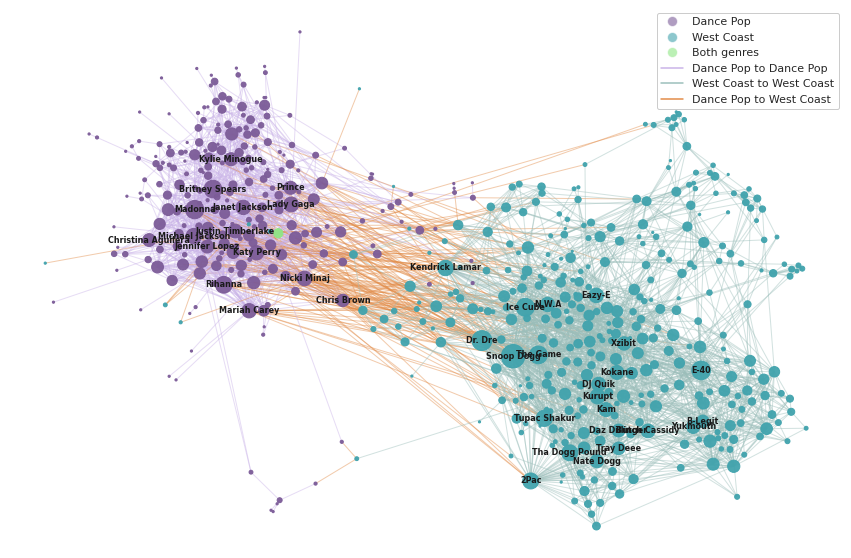

In [ ]:
# Make labels for nodes with degree > 30
label_pos = {}
GCC_label = GCC.copy()
for key in positions.keys():
    if GCC.degree()[key] > 30:
        label_pos[key] = positions[key]
    else:
        GCC_label.remove_node(key)

plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(GCC, positions, node_size=size, node_color=color_map, alpha=0.95)
nx.draw_networkx_edges(GCC, positions, edge_color = edge_colors,  alpha=0.45)
nx.draw_networkx_labels(GCC_label, label_pos, font_size=8, font_weight='bold')
plt.legend(handles=legend_elements, facecolor='white', framealpha=1)
plt.axis('off')
plt.savefig("BasicGraph.png", format="PNG")
plt.show()

## Analysis

Explain ....

**Analysis step 1 - Communities**

We are interested in whether, in addition to the two genres, there should be smaller communities in the network. If we can find communities in the network, we want to investigate the sizes of the communities, and the characteristics of each community. This would be based on text-analysis, such as wordclouds and sentiment analysis. 

To identify the communities, we use the function "best_partition" from the python package "community", which is a pacage that implements community detection. The function compute the partition of the graph nodes which maximises the modularity using the Louvain heuristices. This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.

In [ ]:
#first compute the best partition
partition = community_louvain.best_partition(GCC)

In [ ]:
# Number of communities
print("Number of communities:", max(partition.values())+1)

In [ ]:
# make list containing each community as a dictionary
community_dicts = []
for i in range(max(partition.values())):
    community_dict = {}
    for key in partition:
        if partition[key] == i:
            community_dict[key] = H.degree(key)
    community_dicts.append(community_dict)

We want to inspect how many nodes each community contain. This is shown in the following distribution plot.

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(Communities.index,Communities.values)
for index,value in Communities.iteritems():
    plt.text(index-0.2,value+5,value,fontsize=15)
plt.ylabel('Nodes in community',fontsize=15)
plt.xlabel('Community number',fontsize=15)
plt.title('Sizes of communities',fontsize=20)
plt.xticks(Communities.index)
plt.savefig('CommunitySize.png', format="PNG")
plt.show()

The distribution plot show that we have five largest communities and some smaller ones.

We make a list with some of the names in each community. This is made to be able to look further down in which artists appear in the different communities.

In [ ]:
# finding 10 names of the artists in each community
names = []
for comdict in community_dicts:
    name = nlargest(10, comdict, key=comdict.get)
    names.append((", ").join(name))

Now that we have found some communities in the network, we want to show the network, where the nodes are colored after which community they belong.

In [ ]:
#Create a legend for the different colors and their meaning
legend_elements = [Line2D([0], [0], color="#C9B2E8", label='Dance Pop to Dance Pop'),
                   Line2D([0], [0], color="#9BBEBA", label='West Coast to West Coast'),
                   Line2D([0], [0], color="#E28B47", label="Dance Pop to West Coast")]

In [ ]:
# The network of artists, colored by the communities

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(GCC, positions, node_size=size, node_color=list(partition.values()), alpha=0.95)
nx.draw_networkx_edges(GCC, positions, edge_color = edge_colors,  alpha=0.45)
plt.axis('off')
plt.legend(handles=legend_elements, facecolor='white', framealpha=1)
plt.show()

The plot illustarte the communities. It is easy to see that there are five large communities. It is a little hard to find the small communities, but it make sense because they consist of only a few nodes. The nodes in the communities lies mostly within each genre, but there are a few communities that contain notes from both genres.

Due to the size of the communities, we only want to investigate to two largest communities further with wordclouds. To see if these are different in which words appear most.

In [ ]:
# list the communities
Communities = list(set(partition.values()))
# Find two largest communities
Communities = Counter(list(partition.values())).most_common(2) 
print("The two largest communities:", Communities)

# Make a list with the two largest communities
TwoLargestCom = []

for i in Communities:
    TwoLargestCom.append(i[0])

In [ ]:
# Save the documents in a list with one list for each community

path = r'./wikipages_dance_pop/' 
dance_pop_files = glob.glob(path + "/*.txt")
path = r'./wikipages_west_coast/'
west_coast_files = glob.glob(path + "/*.txt")

community_corpus = []

for i in TwoLargestCom:
    document = []
    for file_path in dance_pop_files:
        with open(file_path, encoding="utf8") as f_input:
            if Path(file_path).stem in list(artists['Artist']):
                name = artists.loc[artists['Artist'] == Path(file_path).stem, 'Artist'].iloc[0]
                if name in list(partition.keys()) and partition[name] == i:
                    document.append(f_input.read())
    for file_path in west_coast_files:
        with open(file_path, encoding="utf8") as f_input:
            if Path(file_path).stem in list(artists['Artist']):
                name = artists.loc[artists['Artist'] == Path(file_path).stem, 'Artist'].iloc[0]
                if name in list(partition.keys()) and partition[name] == i:
                    document.append(f_input.read())
    document = " ".join(document)
    community_corpus.append(document)

We make the wiki text ready to the wordclouds by removing punctuation, stopwords and other wierd word that appears in the wiki text. We set all the words to lowercase.

In [ ]:
# clean the text
community_corpus_clean = [] 
punctuation = string.punctuation + '``' + '--' + '|' + "''" + '\\\\\\' + '||' + ', '
stopwords = nltk.corpus.stopwords.words('english')
wierd = ["r","'s","ref","/ref","the",'the','r','cite','\\\\n', 'name=\\\\\\',
    '\\\\n|','scope=\\\\\\','web|url=http', 'url', 'html', 'https', 'u00e9','web','n',
    'row\\\\\\','web|url=https', 'title', 'album', 'new', 'released', 'song', 'category',
    'style=\\\\\\', '\\\\u2013', 'on', 'i', 'rowspan=\\\\\\','cite', 'u00ebsto']
skip = stopwords + wierd

for document in community_corpus:
    community_tokens = word_tokenize(document) # tokenize
    # remove punctuation and wierd words and set to lower case
    community_corpus_clean.append([word.lower() for word in community_tokens if ((word not in punctuation) and (word not in skip))]) 

In [ ]:
# Calculate the term frequency for each word 
document_TF = []

for document in community_corpus_clean:
    document_TF.append(nltk.FreqDist(document))

In [ ]:
com1_TF = document_TF[0]
com2_TF = document_TF[1]

com1_TFTR = {}
com2_TFTR = {}
c = 1

for key in com1_TF:
    wt_com1 = com1_TF[key]/(com2_TF[key] + c)
    com1_TFTR[key] = com1_TF[key] * wt_com1

for key in com2_TF:
    wt_com2 = com2_TF[key]/(com1_TF[key] + c)
    com2_TFTR[key] = com2_TF[key] * wt_com2

In [ ]:
# make lists containing words n times, where n is based on vals from TFTR dicts
com1_wordcloudlist = []
com2_wordcloudlist = []
import math

for key in com1_TFTR:
    val = math.ceil(com1_TFTR[key]/10)
    com1_wordcloudlist.extend([key] * val)

for key in com2_TFTR:
    val = math.ceil(com2_TFTR[key]/10)
    com2_wordcloudlist.extend([key] * val)

com1_wordcloudlist = (" ").join(com1_wordcloudlist)
com2_wordcloudlist = (" ").join(com2_wordcloudlist)

Now we are ready to create wordclouds for the two communities.

In [ ]:
from wordcloud import WordCloud
wordcloud_1 = WordCloud(max_font_size=40, collocations = False, background_color='white').generate(com1_wordcloudlist)
wordcloud_2 = WordCloud(max_font_size=40, collocations = False, background_color='white').generate(com2_wordcloudlist)

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.title('Community 1', fontsize=20)
plt.axis("off")
plt.show()

The first community contains words such as "cher", "madonna", "rihanna", "beyonce", "shakira" and many other dance pop artist.

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.title('Community 2', fontsize=20)
plt.axis("off")
plt.show()

**Analysis step 2 - Sentiment analysis of the artists**

Now we want to investigate the sentiment of the artists. The sentiment analysis will be made on the artists wikipages. We want to see if there is a difference in the sentiment between the two genres.

The second community contains many west coast artists, like for example; eazy, cube, gangsta, dogg, cypress, kurupt and so on.

**Analysis step 3 - Artist Sentiment based on songs**

**Analysis step 4 - Song Sentiment over time**

In this part we wanted to investigate if the sentiment of the songs change over time. This were
done to see if the two genre over time becomes more similar or is drifting apart. Hopefully if the 
two genres has some of the same spikes or pits, we could link those to real life events. For each 
genre we take the songs which have an release date on Genius, group them by year
and then take the average sentiment of songs in each group.   

In this section we will use sentiment scores based on each individual song. Then to dig 
a little deeper, we will find some spikes and  pits in from the average sentiment, and 
show the most segnificant words for that year using TF-IDF word scores and wordclouds.  

In [ ]:
# Reading artist from csv files 
lyric_dance_pop_df = pd.read_csv('lyric_info_dance_pop_df.csv', sep = '\t')
del lyric_dance_pop_df['Unnamed: 0']
del lyric_dance_pop_df['Unnamed: 0.1']
lyric_dance_pop_df  = lyric_dance_pop_df[lyric_dance_pop_df.release_date != 'unidentified']
lyric_dance_pop_df.head()

lyric_west_coast_df = pd.read_csv('lyric_info_west_coast_df.csv', sep = '\t')
del lyric_west_coast_df['Unnamed: 0']
del lyric_west_coast_df['Unnamed: 0.1']
lyric_west_coast_df = lyric_west_coast_df[lyric_west_coast_df.release_date != 'unidentified']
lyric_west_coast_df.head()

For this analysis part, we use the csv-files which contains a row for each song in the genre. 
Then delete all rows were the release date is unidentified, since we are not going to use
them in this case. In the following we create a new dictionary with the sentiment of each song 
as an extra attribute. 

In [ ]:
def sentiment_song(df):
    sentiment_info = dict()
    count_songs = 0
    for index, row in df.iterrows():  
        song_sent = dict()
        song_sent['song_title'] = row['title'] 
        song_sent['artist'] = row['artist']
        song_sent['year'] = row['release_date'][:4]

        # Calculate sentiment average 
        tokens = clean_songs(row['Song Lyrics'])
        scores = apply_sentiment(tokens)
        song_sent['sentiment'] = scores
            
        if not np.isnan(scores): 
            sentiment_info[count_songs] = song_sent
            count_songs +=1

    return sentiment_info

In [ ]:
sentiment_info_dance_pop = sentiment_song(lyric_dance_pop_df)
sentiment_info_west_coast = sentiment_song(lyric_west_coast_df)

To see the line chart of the avarge sentiemnt pr. year for booth genre, you need to go to our
webpage, since its an interaktive chart written in html. In the following snippets of code, 
we will show have we prepared the data for the interaktive chart.  


In [ ]:
# Prepare data for line plot 
def func_year_sentiment(df): 
    year_sentiment_dict = dict()
    for key in df.keys(): 
        val = df[key]
        year = int(val['year'])
        if not (year > 2020 or year <1920): 
            if not val['year'] in year_sentiment_dict: 
                year_sentiment_dict[val['year']] = []
            year_sentiment_dict[val['year']].append(val['sentiment'])
    return year_sentiment_dict
year_sentiment_dict_dp = func_year_sentiment(sentiment_info_dance_pop)
year_sentiment_dict_wc = func_year_sentiment(sentiment_info_west_coast)


def get_tooltip_html(year, sent, num_songs):
    return """
<div class="p-2">
  <h3><i class="fas fa-music"></i> {}</h3>
  <i class="far fa-file-alt"></i> Sentiment: {} <br>
  <i class="fas fa-microphone-alt"></i> Based on {} songs
</div>
    """.format(year, round(sent, 2), num_songs)

data_points = []
for year in range(1969, 2021):
    sent_dance_pop = None
    sent_west_coat = None
    tooltip_dance_pop = None
    tooltip_west_coat = None

    if str(year) in year_sentiment_dict_dp:
        sentiments = year_sentiment_dict_dp[str(year)]
        sent_dance_pop = sum(sentiments)/len(sentiments)
        tooltip_dance_pop = get_tooltip_html(year, sent_dance_pop, len(sentiments))
    
    if str(year) in year_sentiment_dict_wc:
        sentiments = year_sentiment_dict_wc[str(year)]
        sent_west_coat = sum(sentiments)/len(sentiments)
        tooltip_west_coat = get_tooltip_html(year, sent_west_coat, len(sentiments))

    data_points.append([str(year), sent_dance_pop, tooltip_dance_pop, sent_west_coat, tooltip_west_coat])

print(str(data_points).replace("None", "null"))

The chart clearly had some spikes and pits, and the two genre seemed to follow the same pattern. 
Therefor we want to look deeper into the words for certain years. Could we see why the sentiment 
behaved like it did. Could we by using TF-IDF and wordclouds gain some insight into why 
sentiment rised and fell from year to year. We choose to investigate two different years 
1996 and 2007, for similarities and differences in significant words those years.  

In [ ]:
def clean_songs(input_text): 
    string_of_text = ','
    words = string_of_text.join([song.replace('\\n',' ') for song in input_text]).split()
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    result_out_punctuation = [w.translate(table) for w in words if len(w)>3]
    return result_out_punctuation

In [ ]:
def TF_IDF(row): 
    clean_play_list = clean_songs(row)
    string_clean_play_list = nltk.tokenize.word_tokenize(" ".join(clean_play_list))
    TF = nltk.FreqDist(string_clean_play_list)

    IDF = dict()
    TF_IDF = dict()
    N = len(clean_play_list)
    #print(N)
    for word in set(string_clean_play_list):
        count = 0 
        for song in range(len(clean_play_list)): 
            if word in clean_play_list[song]: 
                count = count +1
        IDF[word] = (math.log(N/(count+1),2))
        TF_IDF[word] = TF.get(word)*IDF[word]
    return TF_IDF

In [ ]:
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 100%%, %d%%)" %(213+random.randint(50, 150), random.randint(50, 90))

def year_wordClouds(df, year, title, recolor = True): 
    lyrics_string = []
    for index, row in df.iterrows(): 
        if row['release_date'][:4] == year: 
            lyrics_string.append(row['Song Lyrics'])
        
    TF_IDF_list = TF_IDF(lyrics_string)

    wordcloud = WordCloud(max_font_size=40, collocations = False, background_color='white').generate((" ").join(TF_IDF_list))
    plt.figure()
    plt.figure(figsize=(20,30))
    if recolor: 
        plt.imshow(wordcloud.recolor(color_func=red_color_func, random_state=3), interpolation="bilinear")
    else: 
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=22)
    plt.savefig(title+'.png')


## Discussion

## Contributions

**1. Motivation**
* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

**2. Basic stats**
* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

**3. Tools, theory and analysis**
* Talk about how you've worked with text, including regular expressions, unicode, etc.
* Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
* How did you use the tools to understand your dataset?

* Explain the overall idea
* Analysis step 1
    * explain what you're interested in     
    * explain the tool
    * apply the tool
    * discuss the outcome
* Analysis step 2
    * explain what you're interested in
    * explain the tool
    * apply the tool
    * discuss the outcome
* Analysis step 3,
... and so on until the analysis is done


**4. Discussion**
* What went well?,
* What is still missing? 
* What could be improved?, Why?

**5. Contributions**
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).
*(It is not OK simply to write "All group members contributed equally".)*